In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")
import json
from itertools import chain
from tqdm.auto import tqdm
from pathlib import Path
from typing import cast, Dict
import subprocess
from praatio import textgrid
import numpy as np
import pandas as pd
from weave import Speech, Utterance, Word, Character, Phone
from weave import BuildUtt

In [2]:
### Read charac-boundary dictionary
word_syll_map = pd.read_csv(Path("../data/mandarin_taiwan_mfa_redelvar.syll.tsv"), sep="\t")\
                  .groupby("ipa").first().drop("word", axis=1)\
                  .to_dict(orient="index")
word_syll_map = cast(Dict[str, Dict[str, str]], word_syll_map)

In [3]:
for speaker_dir in tqdm(Path("../data/seqs_aligned/").glob("*")):
  speaker_id = speaker_dir.name
  out_tg_path = Path(f"../data/seqs_aligned/{speaker_id}.TextGrid")
  mfa_json_path = out_tg_path.with_suffix(".mfa.json")
  if mfa_json_path.exists():
    print("mfa.json exists, delete them if to re-generate")
    break

  mfa_utt_list = []
  for tg_path_x in sorted(speaker_dir.glob("*.TextGrid")):
    fa = textgrid.openTextgrid(str(tg_path_x), False)
    fa_words = fa.getTier("words")
    fa_phones = fa.getTier("phones")
    mfa_wlist = BuildUtt.build_words_phones(fa_words, fa_phones)  #type: ignore
    mfa_words = BuildUtt.build_characters(mfa_wlist, word_syll_map)  #type: ignore
    mfa_utt = Utterance.from_words(mfa_words)
    mfa_utt.utt_id = tg_path_x.stem
    mfa_utt_list.append(mfa_utt)
  mfa_speech = Speech.from_utterances(mfa_utt_list)
  mfa_json_path.write_text(json.dumps(mfa_speech.to_dict())) 

  print(subprocess.run(["sha1sum", str(mfa_json_path)], capture_output=True).stdout.decode().strip())

0it [00:00, ?it/s]

ac7168356c613c1c3d75adf069019467cb15bc80  ../data/seqs_aligned/LBY_GY.mfa.json
fc902fc95008b2c96f62368e699094fde0a21aa6  ../data/seqs_aligned/LZZ_GY.mfa.json
b9c93c164591e1b3d4241d28e06028000bcb4d1c  ../data/seqs_aligned/ZWZ_GY.mfa.json
539b276375b939b959b262ad1dda92c9d0014cf7  ../data/seqs_aligned/HRT_GY.mfa.json
cc9a590329e6e3b859a636ec759d7a04c7565984  ../data/seqs_aligned/XMC_GY.mfa.json
c569ece1fc44b18d77fe268915a6d901d1e450ab  ../data/seqs_aligned/ZZY_GY.mfa.json
371cd78f0597a8d559c87cd033cc40fe1c58a07d  ../data/seqs_aligned/alignment_analysis.csv.mfa.json
0bbc95c7c7098de2d604003e87bb548f15403da2  ../data/seqs_aligned/HYS_GY.mfa.json
583a97b39382ae6c3fd76b15bd539a9e5f877f91  ../data/seqs_aligned/ZMX_GY.mfa.json
75094737e3633abcddadda6464bc54a4752180e9  ../data/seqs_aligned/CZX_GY.mfa.json
b4765123a08ae86ad9b82e569b58433e56b7dcf3  ../data/seqs_aligned/XZZ_GY.mfa.json
9ff2cb0b774d13048414ff5a5c1b77b4cbbea5a1  ../data/seqs_aligned/YQY_GY.mfa.json
ae926811f7eb071272c5a5e85e29fa95bd5c

In [4]:
# data_paths = Path("../data/retro_labels/").glob("*.mfa.json")
data_paths = Path("../data/seqs_aligned/").glob("*.mfa.json")
data_paths = list(data_paths)

## Finding targets

In [11]:
tgt_word = "這樣"
phones_found = []

In [12]:
for data_path_x in tqdm(data_paths):
  data_dict = json.loads(data_path_x.read_text())
  speech = Speech.from_dict(data_dict)
  for utt_x in speech.utterances:
    for word_x in utt_x.words:
      if word_x.label == tgt_word:
        phones_found.append(list(word_x.iter_phones()))

nphone, nphone_dist = np.unique([len(x) for x in phones_found], return_counts=True)
all_phones = set(p.label for p in chain.from_iterable(x for x in phones_found))
phone_list = sorted(phones_found, key=lambda x: len(x), reverse=True)[0]
phone_list = [x.label for x in phone_list]
phone_list = phone_list + sorted(list((all_phones-set(phone_list))))
phone_table = {x: i for i, x in enumerate(phone_list)}

  0%|          | 0/56 [00:00<?, ?it/s]

In [13]:
phone_table

{'ʈʂ': 0, 'o˥˩': 1, 'j': 2, 'a˥˩': 3, 'ŋ': 4}

In [14]:
pho_mat = []
for phones_x in phones_found:
  if len(phones_x) > len(phone_table):
    print("ERROR: Cannot analyze words having multiple tokens of the same phone")
    break
  pho_vec = np.zeros(len(phone_table))
  for pho in phones_x:
    pho_idx = phone_table[pho.label]
    pho_dur = pho.end - pho.start
    pho_vec[pho_idx] = pho_dur
  pho_mat.append(pho_vec)
pho_mat = np.array(pho_mat)

Text(0.5, 0.95, 'OriDict-這樣 (976 toks)')

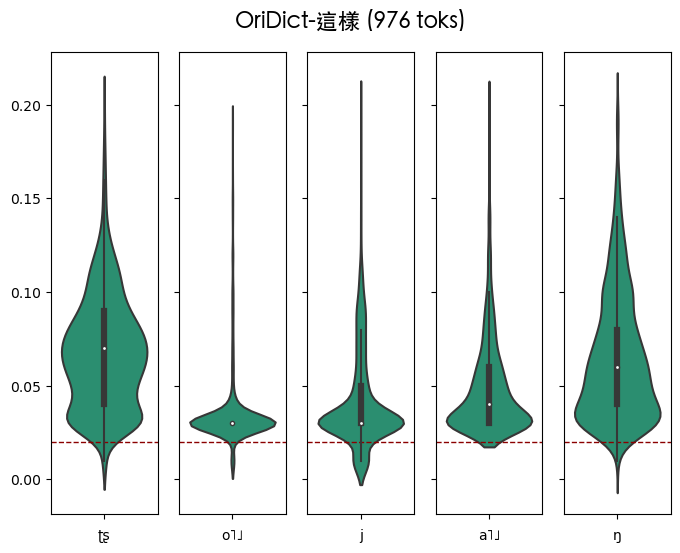

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, len(phone_list), figsize=(8, 6), sharey=True)
for i, ax in enumerate(axes):
  pho_vec = pho_mat[:, i]
  pho_vec = pho_vec[pho_vec < .2]
  ax.axhline(0.02, color="darkred", linewidth=1, linestyle="--")
  sns.violinplot(y=pho_vec, ax=ax, color="#1b9e77")
  ax.set_xlabel(phone_list[i])
fig.suptitle(f"OriDict-{tgt_word} ({len(phones_found)} toks)", 
             fontfamily="HeiTi TC", fontsize=16, y=.95)

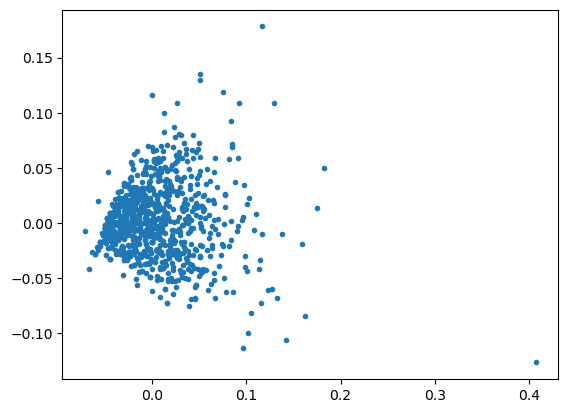

In [16]:
from sklearn.decomposition import PCA
pca = PCA()
pho_proj = pca.fit_transform(pho_mat)
plt.plot(pho_proj[:, 0], pho_proj[:, 1], '.')